In [87]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Question 1

Answer on the joined sheet.

# Question 2

We aim to solve the problem :
\begin{align*}
min \space  f_0(v) = v^TQv + p^Tv
\end{align*}

\begin{align*}
st \space Ax \leq b
\end{align*}

We are using the barrier method. For each centering step, we will solve via the Newton method the problem :
\begin{align*}
min \space f_t(v) = t \space v^TQv + t \space p^Tv + \sum_{i=1}^{n} -log(b_i - [Ax]_i)
\end{align*}  

\begin{align*}
st \space Ax = b
\end{align*}

with $t$ the barrier method parameter.

First, I am going to compute the objective function $f_0$ of the dual problem, and the objective function $f_t$ (noted $f$ in the following code) of the new equality constrained problem. I am also computing the gradient and the hessian of $f$, as it will be required for both the centering step and the backtracking line search.


In [88]:
def f0(v, Q, p):
    return (v.T).dot(Q.dot(v)) + (v.T).dot(p)

def f(v, Q, p, A, b, t):
    return np.squeeze(t*(v.T).dot(Q.dot(v)) + t*(v.T).dot(p) - np.log(b - A.dot(v)).sum())

def grad_f(v, Q, p, A, b, t):
    return t*2*Q.dot(v) + t*p + (A.T).dot(1/ (b - A.dot(v)))
    
def hess_f(v, Q, p, A, b, t):
    return t*2*Q + (A.T).dot(np.diag(np.squeeze(1/ (b - A.dot(v))**2))).dot(A)

## Backtracking line search

The following method return the backtracking line for given parameters. Here I chose $\alpha = 0.2$ and $\beta = 0.7$.

The backtracking line search conditions are that $v + bt \Delta v$ is in the domain of $f$, which corresponds to the condition 

$b - A(v + bt \Delta v)>0$ and that $bt$ is such that $f(v + bt \Delta v) < f(v) + \alpha * bt * \nabla f(v)$.

This method works for stricly feasible point $v$, I test beforehand this condition of $v$.

In [89]:
def backtracking_line_search(v, dv, Q, p, A, b, t, alpha = 0.2, beta = 0.7):
    if np.any(A .dot(v) >= b):
        raise ValueError("Initial point v is not strictly feasible.")
    bt = 1
    while ((b - A.dot(v+bt*dv) <=0).any() or (f(v + bt*dv,Q,p,A,b,t) > f(v,Q,p,A,b,t) + alpha * bt * grad_f(v,Q,p,A,b,t).T.dot(dv))):
        bt = beta * bt
    return bt

## Centering step

The centering step is defined as follow. First, I check if the initial point $v_0$ that is given is strictly feasible (necessary for the backtracking line search).

Then I compute the Newton step $\Delta v_{nt}$ and the square of the Newton decrement $l(v) = \lambda^2 (v)$ for the current $v$. As long as the stopping criterion $\lambda ^2 / 2 < \epsilon$ is not satisfied, I use the backtracking line search to find the parameter $bt$ and update the value of $v = v + bt \Delta v_{nt}$, $\Delta v_{nt}$ and $\lambda (v)$.

The centering step method returns the list $V$ of all $v$ computed at each iteration.

In [90]:
def centering_step(Q, p, A, b, t, v0, eps):
    v = v0
    if np.any(A .dot(v0) >= b):
        raise ValueError("Initial point v0 is not strictly feasible.")

    grad = grad_f(v, Q, p, A, b, t)
    hess = hess_f(v, Q, p, A, b, t)
    inv_hess = np.linalg.solve(hess, np.eye(hess.shape[0]))
    dv_nt = - inv_hess.dot(grad_f(v,Q,p,A,b,t)) # Newton step
    l = np.squeeze(grad.T.dot(inv_hess.dot(grad))) # Newton decrement **2
    
    V = [v]
    while l/2 > eps:
        bt = backtracking_line_search(v, dv_nt, Q, p, A, b, t)
        v = v + bt*dv_nt
        V.append(v)

        grad = grad_f(v, Q, p, A, b, t)
        hess = hess_f(v, Q, p, A, b, t)
        inv_hess = np.linalg.solve(hess, np.eye(hess.shape[0]))
        dv_nt = - inv_hess.dot(grad_f(v,Q,p,A,b,t))
        l = np.squeeze(grad.T.dot(inv_hess.dot(grad)))

    return V

## Barrier method

The following method implements the barrier method. While the precision creterion $2d/t < \epsilon$ is not statisfied, we run centering_step with the barrier parameter $t = \mu t$. If the value of $\mu$ is large, there will be fewer barrier iterations (as $t$ increase fast) but more centering step iterations (as the gap between two steps is very large). We will run the algorithm with different values of $\mu$ to highlight this tradeoff.

In [91]:
def barr_method(Q, p, A, b, v0, eps, mu):
    v = v0
    d = len(b)
    t = 1 
    V = [] # Last value of v given for each centering step
    precision_criterion = [] # List of precision criterion 2d/t for each barrier step
    newton_iterates = [] # Number of iterations of the Newton method for each centering step
    i = 0
    while (2*d)/t > eps:
        i+=1
        Vc = centering_step(Q,p,A,b,t,v,eps)
        v = Vc[-1]
        t = mu * t

        V.append(Vc[-1]) 
        precision_criterion.append((2*d)/t) 
        newton_iterates.append(len(Vc)) 
    return V, precision_criterion, newton_iterates


# Question 3

## Numerical parameters

In [92]:
n = 20
d = 100
lambd = 10
eps = 1e-6
Mu = [2, 3, 5, 10, 15, 20, 30, 50, 100, 200, 1000]

# Random matrix X
X = 30*np.random.rand(n,d)
y = 20*np.random.rand(n)

Q = 0.5 * np.eye(n)
p = -y
A = np.vstack((X.T, -X.T))
b = lambd*np.ones(2*d)

## Tests 

In the following, I run the barrier method for the LASSO problem with the above numerical parameters. I test for several values of $\mu$ and save the outputs that are :

- The sequence of variable iterates $V$ ;
- The values of the precision creterion $2d/t$ ;
- The number of Newton iterates for each centering step.

With the sequence of variable iterates $V$, I can compute the sequence of $f_0$ values and find an estimate of of $f_0 ^*$, chosen as the best value $f_0(v)$ encountered in the precedure (for any value of $\mu$).

Note : The initial point must be strictly feasible. Here all components of $b$ are striclty positive (equal to $\lambda$), therefore the initial point $0$ is strictly feasible. For another problem with $b$ chosen randomly, one should generate a striclty feasible point or adapt the code of the Barrier method with unfeasible starting point (as seen in class).

In [93]:
Newton_iterates = {}

# For the gap (See section 3.3. Result 1)
f0_star = None
f0_values = {}
f0_min_values = {}
Gaps = {} 

# For the precision criterion (See section 3.4. Result 2)
Precision_criterion = {} 

# For the impact on w (See section 3.5 Result 3)
V_min_values = {}


for mu in Mu:
    v0 = np.zeros(n) # The initial point is striclty feasible (since all components of A are > 0)
    V, precision_criterion, newton_iterates = barr_method(Q, p, A, b, v0, eps, mu)
    V_min_values[mu] = V[-1]
    Precision_criterion[mu] = precision_criterion
    Newton_iterates[mu] = newton_iterates
    f0_mu = [f0(v,Q,p) for v in V]
    f0_values[mu] = f0_mu
    min_f0_mu = np.min(f0_mu)
    if f0_star is None or min_f0_mu < f0_star:
        f0_star = min_f0_mu
        
for mu in Mu:
    Gaps[mu] = [f0_star - f0_mu for f0_mu in f0_values[mu]]

## Result 1 : Gap value $f_0(v)-f_0^*$
First, I plot the gap value $f_0(v)-f_0^*$ for each Barrier iterates, and for each Newton iterates. 

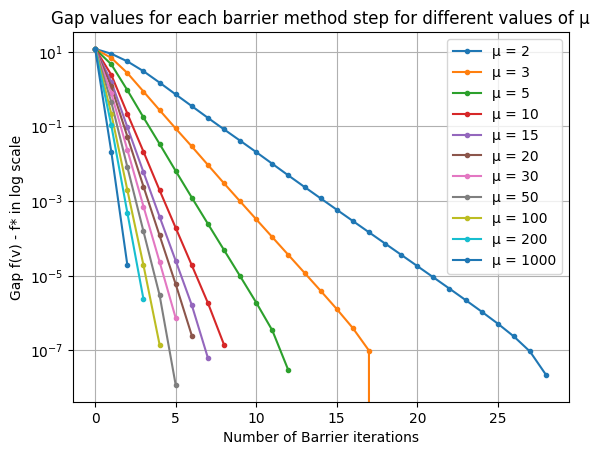

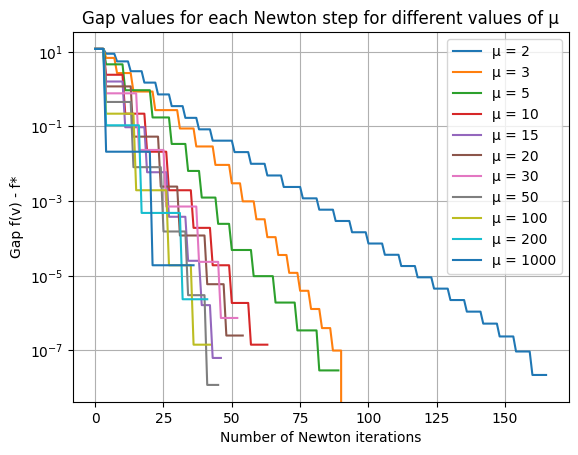

In [94]:
# Print the gap value f(v) - f* for each barrier step 
for mu, values in f0_values.items():
    values = values - f0_star
    indices = range(len(values)) 
    plt.plot(indices, values, marker='.', label=f"µ = {mu}")
plt.xlabel("Number of Barrier iterations")
plt.ylabel("Gap f(v) - f* in log scale")
plt.title("Gap values for each barrier method step for different values of µ")
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Print the gap value f(v) - f* for each Newton step
for mu, values in f0_values.items():
    values = values - f0_star
    resultat = [val for val, n in zip(values, Newton_iterates[mu]) for _ in range(n)]
    indices = range(len(resultat))
    plt.plot(indices, resultat, label=f"µ = {mu}")
plt.xlabel("Number of Newton iterations")
plt.ylabel("Gap f(v) - f*")
plt.title("Gap values for each Newton step for different values of µ")
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

As expected, the error gap between $f_0(v)$ and $f_0^*$ is decreasing faster when $\mu$ is higher (since the barrier parameter $t$ is thus increasing faster) so taking a large $\mu$ makes the convergence faster. 

We can note that when $\mu$ is large (e.g. $\mu = 1000$), more Newton steps are required within a single Barrier iteration (the gap is large between two iterations, so the centering step is slower).

However, we can observe that the final gap achieved is lower for lower values of $\mu$. Hence we can have better results when decreasing a bit $\mu$. There is no need to take the lowest values of $\mu$ (which make the convergence slow) because **intermediate values $\mu \in [10;50]$ leads to very good value for the gap and fast convergence. This highlights the tradeoff mentionned earlier.**

## Result 2 : Precision criterion
Then I plot the precision criterion $2d/t$ for both Barrier iterates and Newton iterates.

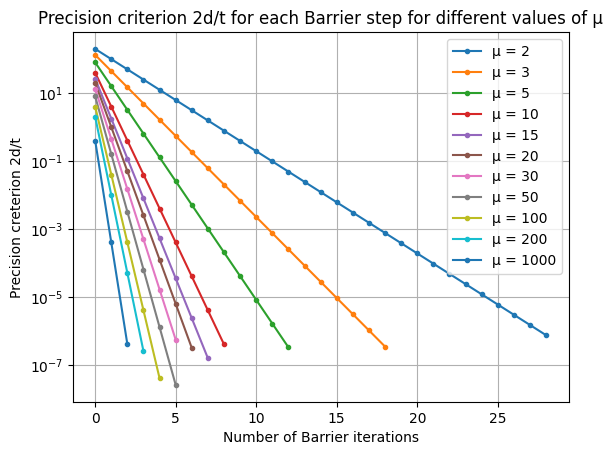

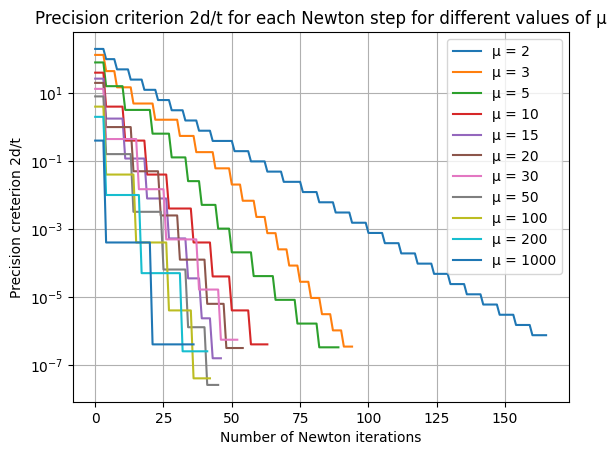

In [95]:
# Print the precision criterion 2d/t for each Barrier step
for mu, precisions in Precision_criterion.items():
    indices = range(len(precisions)) 
    plt.plot(indices, precisions, marker='.', label=f"µ = {mu}")
plt.xlabel("Number of Barrier iterations")
plt.ylabel("Precision creterion 2d/t")
plt.title("Precision criterion 2d/t for each Barrier step for different values of µ")
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Print the precision criterion 2d/t for each Newton step
for mu, precisions in Precision_criterion.items():
    resultat = [val for val, n in zip(precisions, Newton_iterates[mu]) for _ in range(n)]
    indices = range(len(resultat))
    plt.plot(indices, resultat, label=f"µ = {mu}")
plt.xlabel("Number of Newton iterations")
plt.ylabel("Precision creterion 2d/t")
plt.title("Precision criterion 2d/t for each Newton step for different values of µ")
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

We obtain the same type of graphs as for the gap : the precision criterion $2d/t$ is achieved after a larger number of Barrier iterations as $\mu$ is smaller. When looker at the total number of iterations (Barrier and Newton), we also see that when $\mu$ is small, the precision criterion is atteigned after a large number of iterations. 

**<u>Conlusion :</u> an appropriate choice of $\mu$ would be here $\mu = 50$ since in converges fast (not the fastest but many less iterations than lower $\mu$) while achieving the lowest gap and precision criterion. $\mu = 100$ can be another good choice since it converges a bit faster and with a gap and a precision criterion close to the ones of $\mu = 50$.**

## Result 3 : Impact on w

From the solution $v^*$, we can obtain the solution of the LASSO problem $w^*$ with the KKT conditions.

Indeed, the Lagrangian is :
\begin{align*}
L(z, w, v) = 0.5 ||z||_2^2 + v^Tz + \lambda||w||_1 - v^TXw + v^Ty
\end{align*}

For any index $j$, if $w_j \neq 0$, then the first order condition on the Lagrangian with respect to $w_j$ is :
\begin{align*}
\lambda sign(w_j) - X_j^Tv = 0 \qquad [*]
\end{align*}

where $X_j$ is the $j^{th}$ column of $X$.

So to compute $w^*$ from $v^*$, I compute $X^Tv^*$. I keep the index $j$ where the following equality holds :
\begin{align*}
X_j^Tv^* = \lambda
\end{align*}

Let us not $X_J$ the matrix with the column of index $j$ where the equality holds ($J$ is the set of active indices). 

The feasible condition of the primal is :
\begin{align*}
Xw - y = z
\end{align*}

And since $z = -v^*$ (from first order condition on $z$ as mentionned in Question 1) :
\begin{align*}
X_Jw_J^* = y - v^*
\end{align*}

\begin{align*}
w_J^* = (X_J^TX_J)^{-1}X_J^T(y-v^*) 
\end{align*}

Then for all index $j \notin J$, we set $w_j = 0$ (since the condition $[*]$ is not verified).

The following code implements this method to compute $w^*_{estimated}$ from $v^*_{estimated}$ ($v^*_{estimated}$ taken as the value of the last iteration of the Barrier method), for all the values of $\mu$. Then I compute the solution of the primal problem $w^*_{cvx}$ by solving directly the LASSO problem with CVXPY.

Finally, **I plot the difference $||w^*_{estimated} - w^*_{cvx}||_2$ in order to compare the two solutions.**

Note : The condition $[*]$ is checked with a certain tolerance $\epsilon = 10^{-6}$ because of computational approximation.
​

In [ ]:
W_estimated = {}
W_theorical = {}

for mu in Mu:
    v = V_min_values[mu]
    w_dual = np.zeros(X.shape[1])

    # Find the indices J where |X_j^T * v| = lambda
    J_index = []
    for j in range(X.shape[1]):
        if np.isclose(np.abs((X[:, j].T).dot(v)), lambd, atol=1e-6): # check the KKT condition with a tolerance of 1e-6
            J_index.append(j)

    # Compute X_J and w_J as described above
    X_J = X[:, J_index]
    w_J = np.linalg.inv((X_J).T.dot(X_J)).dot(X_J.T.dot(y - v))

    # Update the componetnts of w_dual that are not null 
    for index, j in enumerate(J_index):
        w_dual[j] = w_J[index]
    
    W_estimated[mu] = w_dual

    # Compare with CVXPY
    w = cp.Variable(X.shape[1])
    primal_objective = cp.Minimize(0.5 * cp.norm2(y - X @ w)**2 + lambd * cp.norm1(w))
    problem = cp.Problem(primal_objective)
    problem.solve()
    w_cvx = w.value

    W_theorical[mu] = w_cvx

[]

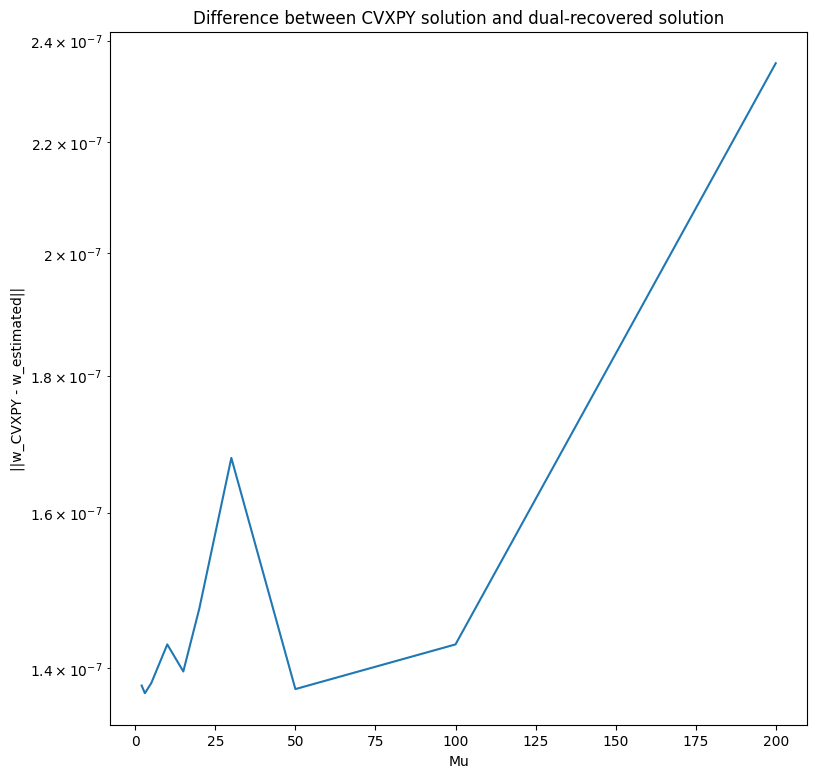

In [102]:
# I removed mu = 1000 because the value is too high and the plot is not readable
Mu = [2, 3, 5, 10, 15, 20, 30, 50, 100, 200]

fig, ax = plt.subplots(figsize = (9, 9))
diff_w = []
for mu in Mu : 
    diff_w.append(np.linalg.norm(W_theorical[mu] - W_estimated[mu]))
ax.plot(Mu, diff_w)
ax.set(xlabel='Mu', ylabel='||w_CVXPY - w_estimated||',
       title='Difference between CVXPY solution and dual-recovered solution')
ax.set_yscale('log')
ax.plot()

We can see that the values of the difference $||w^*_{estimated} - w^*_{cvx}||_2$ are very low (in the order of $10^{-7}$). This means that we have indeed find a good solution $w^*$ for the primal problem from the dual solution $v^*$.

The plot print the difference $||w^*_{estimated} - w^*_{cvx}||_2$ for the different solutions obtained with different values of $\mu$. Here it seems that very small values of $\mu = {2, 3}$ leads to the lowest difference, as well as $\mu = 50$. Previously we concluded that $\mu = {50, 100}$ were good choices in terms of convergence rate and gap. Here $\mu = {50, 100}$ seems to achieve low values of the difference with the ground truth (CVX solution). It confirms my choice of $\mu$ value.

However, when runing several times the whole resolution process, the previous plot changes at each resolution, leading sometimes to differences between the obtained solution and the ground truth that are smaller for $\mu$ around $20-30$ and larger for $\mu$ around $50-100$ (which is not the case here). That is why I am not sure that we can conclude that a value of $\mu$ is better than another by looking as this graph. 

The only conclusion that remains is that the difference $||w^*_{estimated} - w^*_{cvx}||_2$ is much larger for high values of $\mu$. We can see it here for $\mu = 200$. I removed the point where $\mu = 1000$ since the difference was of order $10^{-2}$, thus much larger than the other values (making the plot unreadable). We conclude here that large values of $\mu$ lead, as expected, to solutions that are less close to the optimal one.